<a href="https://colab.research.google.com/github/HoCogThanh/thanh/blob/master/HOG%2BCOLOR_HISTOGRAM%2BSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#---------Kết nối Google Drive--------------
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#--------Các thư viện cần thiết------------

# Xử lý file và hình ảnh
import os
import cv2
import random

# Xử lý dữ liệu và toán học
import numpy as np
from collections import Counter
from statistics import mean, stdev

# Trích xuất đặc trưng
from skimage.feature import hog
from skimage import exposure

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ( accuracy_score, f1_score, classification_report, confusion_matrix,ConfusionMatrixDisplay)
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

'/content/drive/MyDrive/DATASET/Lua' là một thư mục hợp lệ.

Tổng số lượng ảnh trong toàn bộ dữ liệu: 8639


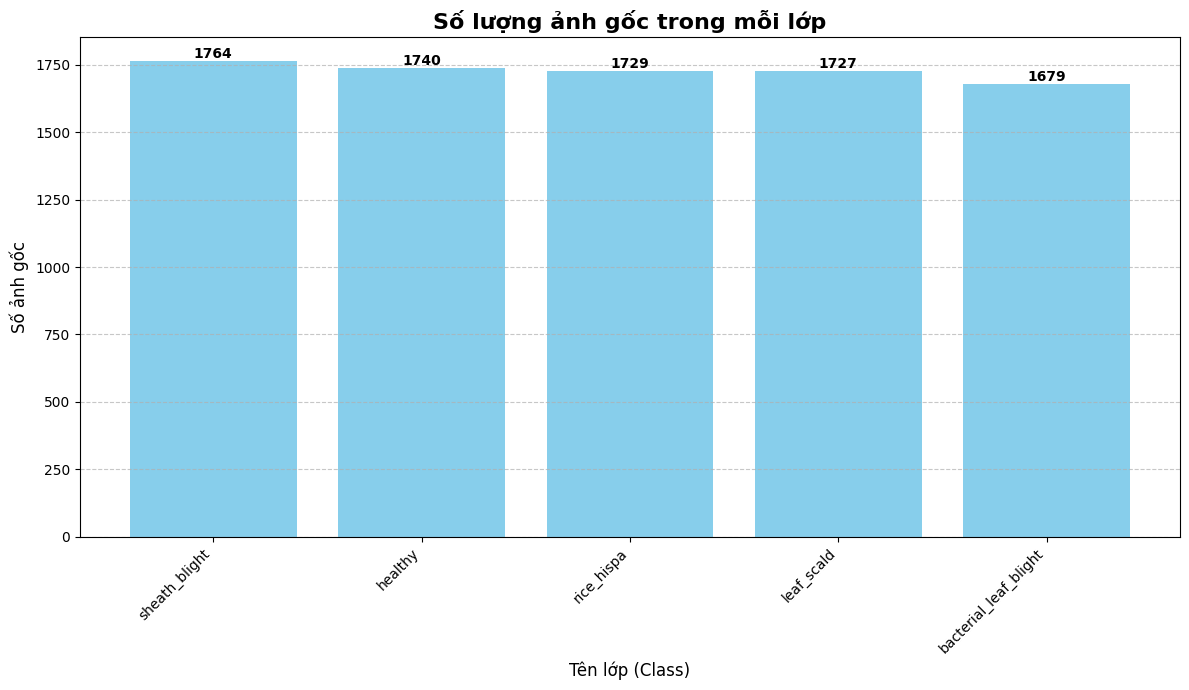

In [ ]:
#----------Hàm thống kê dữ liệu gốc---------

data_dir = "/content/drive/MyDrive/DATASET/Lua"

if not os.path.isdir(data_dir):
    print(f"Lỗi: '{data_dir}' không phải là một thư mục hợp lệ hoặc không tồn tại.")
    exit()
else:
    print(f"'{data_dir}' là một thư mục hợp lệ.")

    # Lấy danh sách các lớp
    categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    if not categories:
        print(f"Không tìm thấy thư mục lớp nào trong '{data_dir}'.")
    else:
        # Thống kê số lượng ảnh trong mỗi lớp
        original_counts = {}
        supported_extensions = ('.png', '.jpg', '.jpeg')

        for category in categories:
            class_path = os.path.join(data_dir, category)
            # Lọc các file có phần mở rộng ảnh hợp lệ
            image_files = [f for f in os.listdir(class_path) if f.lower().endswith(supported_extensions) and os.path.isfile(os.path.join(class_path, f))]
            original_counts[category] = len(image_files)

        # --- In ra tổng số ảnh ---
        total_images = sum(original_counts.values())
        print(f"\nTổng số lượng ảnh trong toàn bộ dữ liệu: {total_images}")

        # --- Vẽ biểu đồ số lượng ảnh gốc ---
        plt.figure(figsize=(12, 7))

        # Sắp xếp các lớp theo số lượng ảnh
        sorted_counts = dict(sorted(original_counts.items(), key=lambda item: item[1], reverse=True))
        bars = plt.bar(sorted_counts.keys(), sorted_counts.values(), color='skyblue')

        plt.title("Số lượng ảnh gốc trong mỗi lớp", fontsize=16, fontweight='bold')
        plt.xlabel("Tên lớp (Class)", fontsize=12)
        plt.ylabel("Số ảnh gốc", fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Ghi số lượng lên cột
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height, str(height),
                     ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

        plt.tight_layout()
        plt.show()

Tổng số mẫu gốc: 8639

Chia tập dữ liệu gốc 75-15-15:
   Train_raw: 6047
   Val_raw:   1296
   Test_raw:  1296

Đang thực hiện augment và trích xuất đặc trưng cho tập huấn luyện...
Tổng số mẫu Train sau khi augment và trích xuất đặc trưng: 30235
Hiển thị ảnh mẫu đã tăng cường:


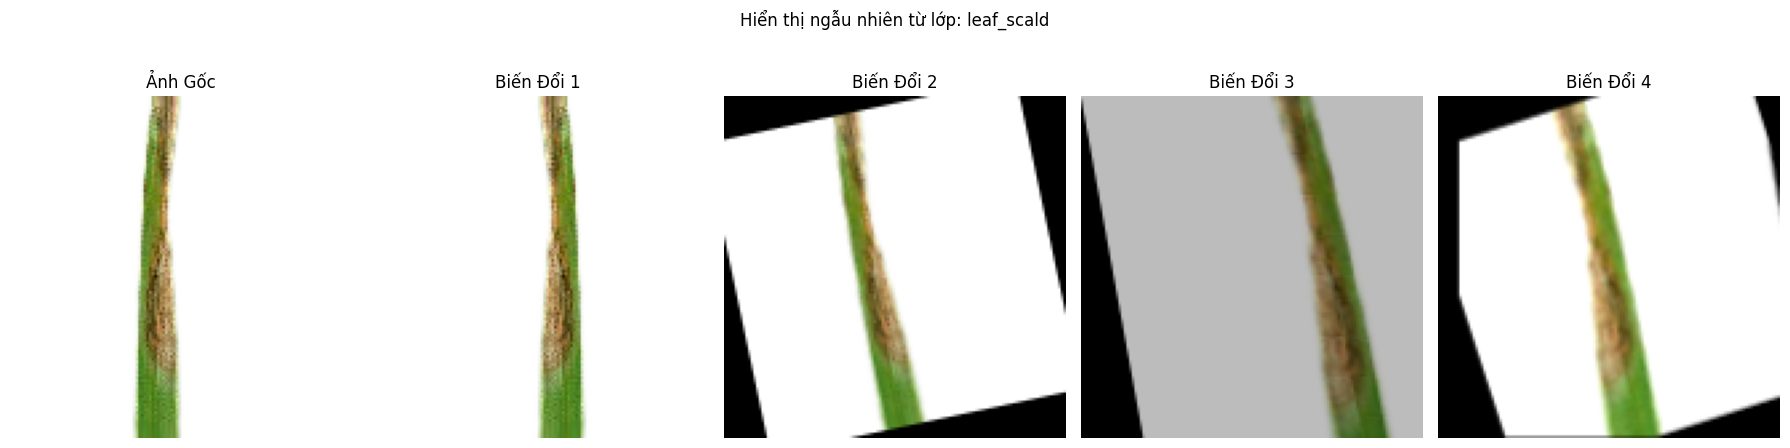


Đang trích xuất đặc trưng cho tập Validation...

Đang trích xuất đặc trưng cho tập Test...

Đang chuẩn hóa dữ liệu HOG - MinMaxScaler
Đã fit transform HOG trên tập train và transform trên tập val/test

Đang chuẩn hóa dữ liệu Color Histogram - MinMaxScaler
Đã fit transform Color Histogram trên tập train và transform trên tập val/test

Đã kết hợp các đặc trưng HOG và Color Histogram đã chuẩn hóa.
Kích thước X_train_final: (30235, 3624)
Kích thước X_val_final: (1296, 3624)
Kích thước X_test_final: (1296, 3624)

Đã lưu scaler (HOG, Color) và train/val/test lần 7 thành công!


In [ ]:

#----------Xử lý dữ liệu và Trích xuất đặc trưng HOG kết hợp Color histogram--------------

data_dir = "/content/drive/MyDrive/DATASET/Lua"
dest_dir = "/content/drive/MyDrive/Lua_16:4_HOG+Color_1"
os.makedirs(dest_dir, exist_ok=True)

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

def rotate_image(img):
    angle = random.randint(-20, 20)
    (h, w) = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
    return cv2.warpAffine(img, M, (w, h))


def flip_image(img):
    return cv2.flip(img, 1)


def shear_image(img):
    shear = random.uniform(-0.2, 0.2)
    M = np.array([[1, shear, 0], [0, 1, 0]], dtype=np.float32)
    (h, w) = img.shape[:2]
    return cv2.warpAffine(img, M, (w, h))


def adjust_brightness(img):
    factor = random.uniform(0.7, 1.3)
    return np.clip(img * factor, 0, 255).astype(np.uint8)


def zoom_image(img, zoom_range=(0.8, 1.2)):
    h, w = img.shape[:2]
    zoom_factor = random.uniform(zoom_range[0], zoom_range[1])

    new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)

    if zoom_factor >= 1.0:
        crop_h, crop_w = int(h / zoom_factor), int(w / zoom_factor)
        crop_h = max(1, crop_h)
        crop_w = max(1, crop_w)

        start_x = random.randint(0, w - crop_w)
        start_y = random.randint(0, h - crop_h)

        cropped_img = img[start_y:start_y+crop_h, start_x:start_x+crop_w]
        return cv2.resize(cropped_img, (w, h), interpolation=cv2.INTER_LINEAR)
    else:
        resized_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        canvas = np.zeros((h, w, 3), dtype=img.dtype)

        start_x = (w - new_w) // 2
        start_y = (h - new_h) // 2

        start_x = max(0, start_x)
        start_y = max(0, start_y)

        canvas[start_y : start_y + new_h, start_x : start_x + new_w] = resized_img
        return canvas


def translate_image(img, translation_range=(-0.1, 0.1)):
    h, w = img.shape[:2]
    tx = random.uniform(translation_range[0], translation_range[1]) * w
    ty = random.uniform(translation_range[0], translation_range[1]) * h
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    return cv2.warpAffine(img, M, (w, h))


def random_cropping(img, min_crop_ratio=0.8):
    h, w = img.shape[:2]

    min_crop_h = int(h * min_crop_ratio)
    min_crop_w = int(w * min_crop_ratio)

    crop_h = random.randint(min_crop_h, h)
    crop_w = random.randint(min_crop_w, w)

    start_x = random.randint(0, w - crop_w)
    start_y = random.randint(0, h - crop_h)

    cropped_img = img[start_y:start_y + crop_h, start_x:start_x + crop_w]
    return cv2.resize(cropped_img, (w, h))

def augment_image(img, n_augments=4):
    images = [img]
    for _ in range(n_augments):
        aug_img = img.copy()

        transformations = [
            rotate_image,
            flip_image,
            shear_image,
            adjust_brightness,
            zoom_image,
            translate_image,
            random_cropping
        ]
        random.shuffle(transformations)

        num_transforms_to_apply = random.randint(1, len(transformations))
        for t_func in transformations[:num_transforms_to_apply]:
            aug_img = t_func(aug_img)

        images.append(aug_img)
    return images

def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    hist_h = cv2.calcHist([hsv_image], [0], None, [bins[0]], [0, 180])
    hist_s = cv2.calcHist([hsv_image], [1], None, [bins[1]], [0, 256])
    hist_v = cv2.calcHist([hsv_image], [2], None, [bins[2]], [0, 256])

    hist_h = cv2.normalize(hist_h, hist_h).flatten()
    hist_s = cv2.normalize(hist_s, hist_s).flatten()
    hist_v = cv2.normalize(hist_v, hist_v).flatten()

    return np.concatenate((hist_h, hist_s, hist_v))

X_original, y_original = [], []

for idx, category in enumerate(categories):
    class_path = os.path.join(data_dir, category)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (128, 128))
        X_original.append(img)
        y_original.append(idx)

X_original = np.array(X_original)
y_original = np.array(y_original)
print(f"Tổng số mẫu gốc: {X_original.shape[0]}")

X_train_raw, X_temp_raw, y_train_raw, y_temp_raw = train_test_split(
    X_original, y_original, test_size=0.3, stratify=y_original, random_state=None
)
X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(
    X_temp_raw, y_temp_raw, test_size=0.5, stratify=y_temp_raw, random_state=None
)

print(f"\nChia tập dữ liệu gốc 75-15-15:")
print(f"   Train_raw: {len(X_train_raw)}")
print(f"   Val_raw:   {len(X_val_raw)}")
print(f"   Test_raw:  {len(X_test_raw)}")



X_train_hog, X_train_color = [], []
y_train_augmented = []

print("\nĐang thực hiện augment và trích xuất đặc trưng cho tập huấn luyện...")
for i, img in enumerate(X_train_raw):
    augmented_images = augment_image(img, n_augments=4)
    for aug_img in augmented_images:
        gray = cv2.cvtColor(aug_img, cv2.COLOR_BGR2GRAY)

        hog_features = hog(
            gray,
            pixels_per_cell=(16, 16),
            cells_per_block=(4, 4),
            block_norm='L1-sqrt',
            feature_vector=True,
            visualize=False
        )
        X_train_hog.append(hog_features)

        # Trích xuất Histogram màu
        color_hist_features = extract_color_histogram(aug_img)
        X_train_color.append(color_hist_features)

        y_train_augmented.append(y_train_raw[i])

X_train_hog = np.array(X_train_hog)
X_train_color = np.array(X_train_color)
y_train_final = np.array(y_train_augmented)

print(f"Tổng số mẫu Train sau khi augment và trích xuất đặc trưng: {X_train_hog.shape[0]}")

print("Hiển thị ảnh mẫu đã tăng cường:")
random_category = random.choice(categories)
random_class_path = os.path.join(data_dir, random_category)
random_image_name = random.choice(os.listdir(random_class_path))
random_image_path = os.path.join(random_class_path, random_image_name)

sample_img = cv2.imread(random_image_path)
if sample_img is not None:
    sample_img = cv2.resize(sample_img, (128, 128))
    sample_augmented_images = augment_image(sample_img, n_augments=4)

    fig, axes = plt.subplots(1, 5, figsize=(18, 5))
    axes[0].imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Ảnh Gốc")
    axes[0].axis('off')

    for i, aug_img in enumerate(sample_augmented_images[1:6]):
        axes[i+1].imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
        axes[i+1].set_title(f"Biến Đổi {i+1}")
        axes[i+1].axis('off')

    plt.suptitle(f"Hiển thị ngẫu nhiên từ lớp: {random_category}")
    plt.tight_layout()
    plt.show()
else:
    print(f"Không thể tải ảnh mẫu từ: {random_image_path}")


X_val_hog, X_val_color = [], []
print("\nĐang trích xuất đặc trưng cho tập Validation...")
for i, img in enumerate(X_val_raw):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_features = hog(
        gray, pixels_per_cell=(16, 16), cells_per_block=(4, 4),
        block_norm='L1-sqrt', feature_vector=True, visualize=False
    )
    X_val_hog.append(hog_features)

    color_hist_features = extract_color_histogram(img)
    X_val_color.append(color_hist_features)

y_val_final = np.array(y_val_raw)
X_val_hog = np.array(X_val_hog)
X_val_color = np.array(X_val_color)


X_test_hog, X_test_color = [], []
print("\nĐang trích xuất đặc trưng cho tập Test...")
for i, img in enumerate(X_test_raw):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_features = hog(
        gray, pixels_per_cell=(16, 16), cells_per_block=(4, 4),
        block_norm='L1-sqrt', feature_vector=True, visualize=False
    )
    X_test_hog.append(hog_features)

    color_hist_features = extract_color_histogram(img)
    X_test_color.append(color_hist_features)

y_test_final = np.array(y_test_raw)
X_test_hog = np.array(X_test_hog)
X_test_color = np.array(X_test_color)


print("\nĐang chuẩn hóa dữ liệu HOG - MinMaxScaler")
scaler_hog = MinMaxScaler()
scaler_hog.fit(X_train_hog)

X_train_hog_scaled = scaler_hog.transform(X_train_hog)
X_val_hog_scaled = scaler_hog.transform(X_val_hog)
X_test_hog_scaled = scaler_hog.transform(X_test_hog)
print('Đã fit transform HOG trên tập train và transform trên tập val/test')

print("\nĐang chuẩn hóa dữ liệu Color Histogram - MinMaxScaler")
scaler_color = MinMaxScaler()
scaler_color.fit(X_train_color)

X_train_color_scaled = scaler_color.transform(X_train_color)
X_val_color_scaled = scaler_color.transform(X_val_color)
X_test_color_scaled = scaler_color.transform(X_test_color)
print('Đã fit transform Color Histogram trên tập train và transform trên tập val/test')

# ----
X_train_final = np.concatenate((X_train_hog_scaled, X_train_color_scaled), axis=1)
X_val_final = np.concatenate((X_val_hog_scaled, X_val_color_scaled), axis=1)
X_test_final = np.concatenate((X_test_hog_scaled, X_test_color_scaled), axis=1)
print("\nĐã kết hợp các đặc trưng HOG và Color Histogram đã chuẩn hóa.")
print(f"Kích thước X_train_final: {X_train_final.shape}")
print(f"Kích thước X_val_final: {X_val_final.shape}")
print(f"Kích thước X_test_final: {X_test_final.shape}")

train_round = 1
while (os.path.exists(os.path.join(dest_dir, f"X_train{train_round}.npy")) or
       os.path.exists(os.path.join(dest_dir, f"X_val{train_round}.npy")) or
       os.path.exists(os.path.join(dest_dir, f"X_test{train_round}.npy"))):
    train_round += 1

joblib.dump(scaler_hog, os.path.join(dest_dir, f"scaler_hog_{train_round}.pkl"))
joblib.dump(scaler_color, os.path.join(dest_dir, f"scaler_color_{train_round}.pkl"))
np.save(os.path.join(dest_dir, f"X_train{train_round}.npy"), X_train_final)
np.save(os.path.join(dest_dir, f"y_train{train_round}.npy"), y_train_final)
np.save(os.path.join(dest_dir, f"X_val{train_round}.npy"), X_val_final)
np.save(os.path.join(dest_dir, f"y_val{train_round}.npy"), y_val_final)
np.save(os.path.join(dest_dir, f"X_test{train_round}.npy"), X_test_final)
np.save(os.path.join(dest_dir, f"y_test{train_round}.npy"), y_test_final)
print(f"\nĐã lưu scaler (HOG, Color) và train/val/test lần {train_round} thành công!")


===== Trực Quan Hóa Ảnh Mẫu và Đặc Trưng HOG =====

Số lượng đặc trưng HOG trích xuất: 3600


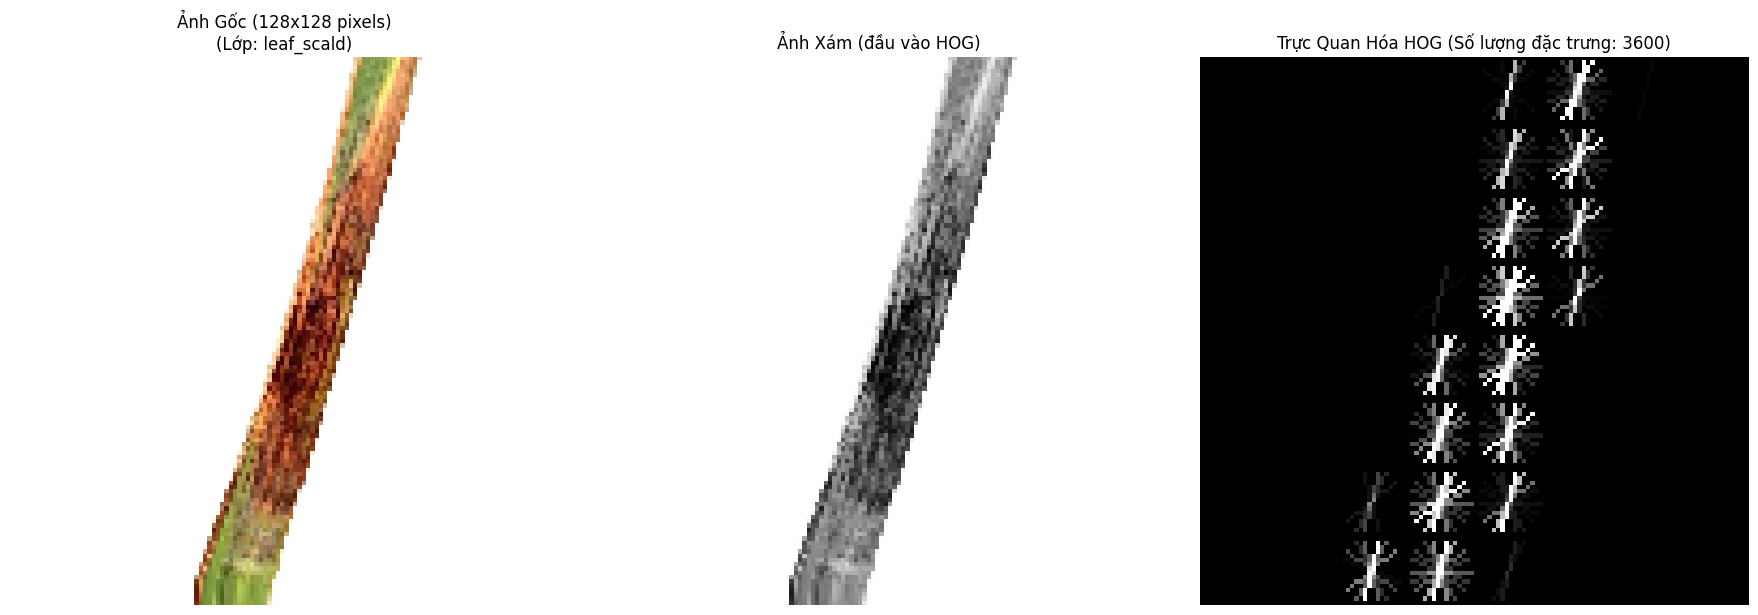

In [ ]:
#------Lấy ngẫu nhiên 1 ảnh gốc để hiện thị ra ảnh xám và trích xuất HOG của nó-------

DATA_DIR = "/content/drive/MyDrive/DATASET/Lua"
categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]
HOG_IMAGE_SIZE = (128, 128)
HOG_PIXELS_PER_CELL = (16, 16)
HOG_CELLS_PER_BLOCK = (4, 4)



random_category_name = np.random.choice(categories)
random_class_path = os.path.join(DATA_DIR, random_category_name)


if not os.listdir(random_class_path):
    print(f"Lỗi: Thư mục '{random_class_path}' trống. Không thể chọn ảnh mẫu.")
    exit()

random_image_name = np.random.choice(os.listdir(random_class_path))
random_image_path = os.path.join(random_class_path, random_image_name)

# Đọc ảnh
sample_img = cv2.imread(random_image_path)

if sample_img is None:
    print(f"Lỗi: Không thể đọc ảnh từ đường dẫn: {random_image_path}")
else:

    sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)


    sample_img_resized = cv2.resize(sample_img_rgb, HOG_IMAGE_SIZE)


    sample_img_gray = cv2.cvtColor(sample_img_resized, cv2.COLOR_RGB2GRAY)



    hog_features, hog_image = hog(
        sample_img_gray,
        pixels_per_cell=HOG_PIXELS_PER_CELL,
        cells_per_block=HOG_CELLS_PER_BLOCK,
        feature_vector=True,
        visualize=True
    )


    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))



    print(f"\nSố lượng đặc trưng HOG trích xuất: {len(hog_features)}")


    fig, axes = plt.subplots(1, 3, figsize=(18, 6))


    axes[0].imshow(sample_img_resized)
    axes[0].set_title(f"Ảnh Gốc ({HOG_IMAGE_SIZE[0]}x{HOG_IMAGE_SIZE[1]} pixels)\n(Lớp: {random_category_name})")
    axes[0].axis('off')


    axes[1].imshow(sample_img_gray, cmap='gray')
    axes[1].set_title("Ảnh Xám (đầu vào HOG)")
    axes[1].axis('off')


    axes[2].imshow(hog_image_rescaled, cmap='gray')
    axes[2].set_title(f"Trực Quan Hóa HOG (Số lượng đặc trưng: {len(hog_features)})")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
#-----------Tìm tham số tối ưu cho mô hình SVM----------
import os
import numpy as np
import joblib
from itertools import product
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# ====== Cấu hình đường dẫn ======
DATA_DIR = '/content/drive/MyDrive/Lua_16:4_HOG+Color_1'
RESULT_PATH = '/content/drive/MyDrive/svm_search_results.pkl'

try:
    X_train = np.load(os.path.join(DATA_DIR, 'X_train2.npy'))
    X_val   = np.load(os.path.join(DATA_DIR, 'X_val2.npy'))
    y_train = np.load(os.path.join(DATA_DIR, 'y_train2.npy'))
    y_val   = np.load(os.path.join(DATA_DIR, 'y_val2.npy'))
    print("Đã tải dữ liệu thành công!")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy tệp dữ liệu trong thư mục '{DATA_DIR}'.")
    exit()

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

best_score = -1
best_params = {}
results = []

param_grid = {
    'C': [0.01, 0.1, 5, 20, 100],
    'kernel': ['rbf'],
    'gamma': ['scale', 0.01, 0.001]
}

all_param_combinations = list(product(param_grid['C'], param_grid['kernel'], param_grid['gamma']))

try:
    with open(RESULT_PATH, 'rb') as f:
        results = joblib.load(f)
    print(f"Đã tải {len(results)} kết quả đã huấn luyện trước đó.")

    if results:
        print("\n--- Chi tiết các kết quả đã huấn luyện trước đó ---")
        for i, res in enumerate(results):
            c_val = res.get('C', 'N/A')
            kernel_val = res.get('kernel', 'N/A')
            gamma_val = res.get('gamma', 'N/A')
            score_val = res.get('score', 'N/A')
            print(f"  Lần {i+1}: C={c_val}, kernel={kernel_val}, gamma={gamma_val}, Score: {score_val:.4f}")

        current_best_result = max(results, key=lambda x: x['score'])
        best_score = current_best_result['score']
        best_params = {k: current_best_result[k] for k in ['C', 'kernel', 'gamma'] if k in current_best_result}
        print(f"\nCập nhật best_score từ dữ liệu đã lưu: {best_score:.4f}")
        print(f"Cập nhật best_params từ dữ liệu đã lưu: {best_params}")

except FileNotFoundError:
    print("Không tìm thấy kết quả đã lưu, bắt đầu từ đầu.")


trained_combinations = [(res['C'], res['kernel'], res['gamma']) for res in results]
untrained_params = [
    {'C': C, 'kernel': kernel, 'gamma': gamma}
    for (C, kernel, gamma) in all_param_combinations
    if (C, kernel, gamma) not in trained_combinations
]

if not untrained_params:
    print("\nTất cả tổ hợp đã được huấn luyện.")
else:
    print(f"\nBắt đầu huấn luyện {len(untrained_params)} tổ hợp còn lại bằng GridSearchCV...")

    svm = SVC()
    grid_search = GridSearchCV(estimator=svm,
                                param_grid=untrained_params,
                                scoring='accuracy',
                                cv=5,
                                verbose=2,
                                n_jobs=-1)

    grid_search.fit(X_train, y_train)

    for i in range(len(grid_search.cv_results_['params'])):
        p = grid_search.cv_results_['params'][i]
        mean_score = grid_search.cv_results_['mean_test_score'][i]
        print(f"   C={p['C']}, gamma={p['gamma']}, kernel={p['kernel']} | CV Score: {mean_score:.4f}")
        results.append({
            'C': p['C'],
            'kernel': p['kernel'],
            'gamma': p['gamma'],
            'score': mean_score
        })

        if mean_score > best_score:
            best_score = mean_score
            best_params = {'C': p['C'], 'kernel': p['kernel'], 'gamma': p['gamma']}
            # Huấn luyện lại mô hình tốt nhất trên train và lưu
            best_model = SVC(**best_params)
            best_model.fit(X_train, y_train)
            joblib.dump(best_model, '/content/drive/MyDrive/best_svm_model.pkl')
            print(f"   Lưu mô hình tốt nhất với độ chính xác: {best_score:.4f}")

    # ====== Lưu lại kết quả sau khi huấn luyện thêm ======
    with open(RESULT_PATH, 'wb') as f:
        joblib.dump(results, f)
    print("Đã lưu tiến độ vào svm_search_results.pkl")

print("\n--- Hoàn tất tìm kiếm tham số ---")
print("Best params found:", best_params)
print(f"Best validation score: {best_score:.4f}")



Đã tải dữ liệu thành công!
Đã tải 15 kết quả đã huấn luyện trước đó.

--- Chi tiết các kết quả đã huấn luyện trước đó ---
  Lần 1: C=0.01, kernel=rbf, gamma=scale, Score: 0.7222
  Lần 2: C=0.01, kernel=rbf, gamma=0.01, Score: 0.7014
  Lần 3: C=0.01, kernel=rbf, gamma=0.001, Score: 0.4066
  Lần 4: C=0.1, kernel=rbf, gamma=scale, Score: 0.8017
  Lần 5: C=0.1, kernel=rbf, gamma=0.01, Score: 0.7932
  Lần 6: C=0.1, kernel=rbf, gamma=0.001, Score: 0.7099
  Lần 7: C=5, kernel=rbf, gamma=scale, Score: 0.9491
  Lần 8: C=5, kernel=rbf, gamma=0.01, Score: 0.9244
  Lần 9: C=5, kernel=rbf, gamma=0.001, Score: 0.8318
  Lần 10: C=20, kernel=rbf, gamma=scale, Score: 0.9606
  Lần 11: C=20, kernel=rbf, gamma=0.01, Score: 0.9498
  Lần 12: C=20, kernel=rbf, gamma=0.001, Score: 0.8719
  Lần 13: C=100, kernel=rbf, gamma=scale, Score: 0.9583
  Lần 14: C=100, kernel=rbf, gamma=0.01, Score: 0.9560
  Lần 15: C=100, kernel=rbf, gamma=0.001, Score: 0.8966

Cập nhật best_score từ dữ liệu đã lưu: 0.9606
Cập nhật be


Số lượng mẫu:
- Train: 30235 mẫu
- Validation: 1296 mẫu
- Test: 1296 mẫu

Số lượng mẫu theo từng lớp trong tập Train:
  bacterial_leaf_blight (0): 5875 mẫu
  leaf_scald (1): 6045 mẫu
  rice_hispa (2): 6050 mẫu
  healthy (3): 6090 mẫu
  sheath_blight (4): 6175 mẫu

Số lượng mẫu theo từng lớp trong tập Validation:
  bacterial_leaf_blight (0): 252 mẫu
  leaf_scald (1): 259 mẫu
  rice_hispa (2): 259 mẫu
  healthy (3): 261 mẫu
  sheath_blight (4): 265 mẫu

Số lượng mẫu theo từng lớp trong tập Test:
  bacterial_leaf_blight (0): 252 mẫu
  leaf_scald (1): 259 mẫu
  rice_hispa (2): 260 mẫu
  healthy (3): 261 mẫu
  sheath_blight (4): 264 mẫu

 Mô hình vòng 1 đã tồn tại. Tải và đánh giá lại.
   Đã tải | Test - Accuracy: 93.75% | F1-score: 0.9376

 Mô hình vòng 2 đã tồn tại. Tải và đánh giá lại.
   Đã tải | Test - Accuracy: 94.68% | F1-score: 0.9468

 Mô hình vòng 3 đã tồn tại. Tải và đánh giá lại.
   Đã tải | Test - Accuracy: 94.75% | F1-score: 0.9477

 Mô hình vòng 4 đã tồn tại. Tải và đánh giá

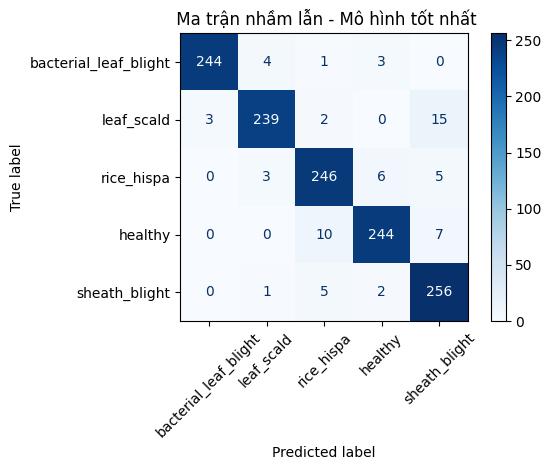

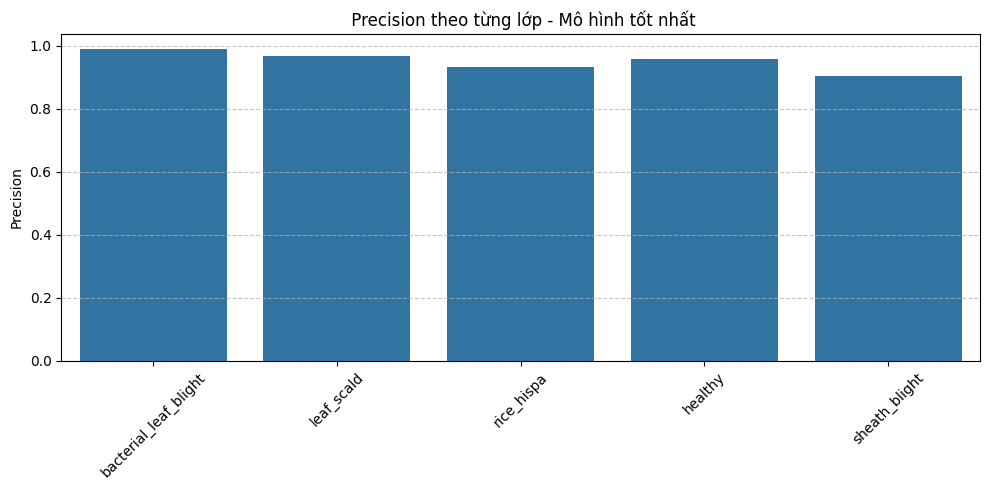


 Đã lưu mô hình SVM tốt nhất với F1-score: 0.9484 vào: /content/drive/MyDrive/Lua_16:4_HOG+Color_1/svm_model_best.pkl


In [ ]:
# ---------------- Huấn luyện mô hình HOG + Color + SVM  7 tập dữ liệu được chia ngẫu nhiên từ dữ liệu gốc --------------------

DATA_DIR = "/content/drive/MyDrive/Lua_16:4_HOG+Color_1"
MODEL_SAVE_DIR = os.path.join(DATA_DIR, 'saved_svm_rounds')
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

X_train_initial = np.load(os.path.join(DATA_DIR, 'X_train1.npy'))
X_val_initial   = np.load(os.path.join(DATA_DIR, 'X_val1.npy'))
X_test_initial  = np.load(os.path.join(DATA_DIR, 'X_test1.npy'))

y_train_initial = np.load(os.path.join(DATA_DIR, 'y_train1.npy'))
y_val_initial   = np.load(os.path.join(DATA_DIR, 'y_val1.npy'))
y_test_initial  = np.load(os.path.join(DATA_DIR, 'y_test1.npy'))

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

print(f"\nSố lượng mẫu:")
print(f"- Train: {len(X_train_initial)} mẫu")
print(f"- Validation: {len(X_val_initial)} mẫu")
print(f"- Test: {len(X_test_initial)} mẫu")


def print_class_distribution(y, split_name):
    print(f"\nSố lượng mẫu theo từng lớp trong tập {split_name}:")
    counter = Counter(y)
    # Sắp xếp các lớp
    sorted_labels = sorted(counter.keys())
    for label in sorted_labels:
        count = counter[label]
        class_name = categories[label] if label < len(categories) else f"Lớp {label}"
        print(f"  {class_name} ({label}): {count} mẫu")

print_class_distribution(y_train_initial, "Train")
print_class_distribution(y_val_initial, "Validation")
print_class_distribution(y_test_initial, "Test")

accuracy_list = []
f1_list = []
best_f1 = -1
best_model = None
best_preds = None
best_y_test = None

num_rounds = 7
start_round = 1

for i in range(1, num_rounds + 1):
    model_path_round = os.path.join(MODEL_SAVE_DIR, f'svm_model_round_{i}.pkl')
    if not os.path.exists(model_path_round):
        start_round = i
        print(f"\n Vòng huấn luyện chưa hoàn thành. Bắt đầu từ vòng {start_round}.")
        break
    else:
        print(f"\n Mô hình vòng {i} đã tồn tại. Tải và đánh giá lại.")


        X_test_round = np.load(os.path.join(DATA_DIR, f'X_test{i}.npy'))
        y_test_round = np.load(os.path.join(DATA_DIR, f'y_test{i}.npy'))


      #  X_val_round = np.load(os.path.join(DATA_DIR, f'X_val{i}.npy'))
       # y_val_round = np.load(os.path.join(DATA_DIR, f'y_val{i}.npy'))

        # Tải mô hình
        loaded_model = joblib.load(model_path_round)

        # Dự đoán và đánh giá trên test
        y_pred_test_loaded = loaded_model.predict(X_test_round)
        acc_test_loaded = accuracy_score(y_test_round, y_pred_test_loaded)
        f1_test_loaded = f1_score(y_test_round, y_pred_test_loaded, average='weighted')

        # Dự đoán và đánh giá trên validation
       # y_pred_val_loaded = loaded_model.predict(X_val_round)
       # acc_val_loaded = accuracy_score(y_val_round, y_pred_val_loaded)
       # f1_val_loaded = f1_score(y_val_round, y_pred_val_loaded, average='weighted')

        # Ghi lại kết quả
        accuracy_list.append(acc_test_loaded)
        f1_list.append(f1_test_loaded)

        print(f"   Đã tải | Test - Accuracy: {acc_test_loaded*100:.2f}% | F1-score: {f1_test_loaded:.4f}")
       # print(f"          | Val  - Accuracy: {acc_val_loaded*100:.2f}% | F1-score: {f1_val_loaded:.4f}")

        # Cập nhật mô hình tốt nhất theo F1-score test
        if f1_test_loaded > best_f1:
            best_f1 = f1_test_loaded
            best_model = loaded_model
            best_preds = y_pred_test_loaded
            best_y_test = y_test_round



# Bắt đầu vòng lặp huấn luyện từ vòng đã xác định
for i in range(start_round, num_rounds + 1):
    model_path_round = os.path.join(MODEL_SAVE_DIR, f'svm_model_round_{i}.pkl')

    # Nếu mô hình cho vòng này đã tồn tại, bỏ qua huấn luyện
    if os.path.exists(model_path_round):
        #print(f"\n Vòng huấn luyện SVM thứ {i} đã hoàn thành trước đó. Bỏ qua huấn luyện lại.")
        continue

    print(f"\n Bắt đầu huấn luyện SVM vòng thứ {i}:")

    # Tải dữ liệu cho vòng hiện tại
    X_train = np.load(os.path.join(DATA_DIR, f'X_train{i}.npy'))
    X_val   = np.load(os.path.join(DATA_DIR, f'X_val{i}.npy'))
    X_test  = np.load(os.path.join(DATA_DIR, f'X_test{i}.npy'))

    y_train = np.load(os.path.join(DATA_DIR, f'y_train{i}.npy'))
    y_val   = np.load(os.path.join(DATA_DIR, f'y_val{i}.npy'))
    y_test  = np.load(os.path.join(DATA_DIR, f'y_test{i}.npy'))

    # Khởi tạo và huấn luyện mô hình
    model = SVC(kernel='rbf', C=20.0, gamma='scale')
    model.fit(X_train, y_train)

    # Dự đoán trên test set
    y_pred_test = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test, average='weighted')

    # Dự đoán trên validation set
  #  y_pred_val = model.predict(X_val)
   # acc_val = accuracy_score(y_val, y_pred_val)
   # f1_val = f1_score(y_val, y_pred_val, average='weighted')

    accuracy_list.append(acc_test)
    f1_list.append(f1_test)

    print(f" Test  | Accuracy: {acc_test*100:.2f}% | F1-score: {f1_test:.4f}")
   # print(f" Val   | Accuracy: {acc_val*100:.2f}% | F1-score: {f1_val:.4f}")

    # Cập nhật mô hình tốt nhất
    if f1_test > best_f1:
        best_f1 = f1_test
        best_model = model
        best_preds = y_pred_test
        best_y_test = y_test

    # Lưu mô hình của vòng hiện tại
    joblib.dump(model, model_path_round)
    print(f" Đã lưu mô hình vòng {i} vào: {model_path_round}")


# ==== Tổng kết ====
print("\n Kết quả tổng hợp:")
if accuracy_list: # Đảm bảo danh sách không rỗng trước khi tính toán
    print(f"- Accuracy trung bình: {mean(accuracy_list)*100:.2f}%")
    print(f"- Accuracy std       : {stdev(accuracy_list)*100:.2f}")
    print(f"- F1-score trung bình: {mean(f1_list):.4f}")
    print(f"- F1-score std       : {stdev(f1_list):.4f}")
else:
    print("- Không có kết quả nào được ghi nhận.")

# ==== In kết quả mô hình tốt nhất ====
if best_model:
    print("\n Mô hình có F1-score cao nhất:")
    print(f"- F1-score: {best_f1:.4f}")
    print(classification_report(best_y_test, best_preds, target_names=categories))

    # ==== Vẽ ma trận nhầm lẫn ====
    cm = confusion_matrix(best_y_test, best_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(" Ma trận nhầm lẫn - Mô hình tốt nhất")

    plt.tight_layout()
    plt.show()

    # ==== Vẽ biểu đồ precision theo từng lớp ====
    report = classification_report(best_y_test, best_preds, target_names=categories, output_dict=True)
    precision_values = [report[cat]['precision'] for cat in categories]

    plt.figure(figsize=(10, 5))
    sns.barplot(x=categories, y=precision_values)
    plt.ylabel("Precision")
    plt.title(" Precision theo từng lớp - Mô hình tốt nhất")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # ==== Lưu mô hình tốt nhất  ====
    model_best_path = os.path.join(DATA_DIR, 'svm_model_best.pkl')
    joblib.dump(best_model, model_best_path)
    print(f"\n Đã lưu mô hình SVM tốt nhất với F1-score: {best_f1:.4f} vào: {model_best_path}")
else:
    print("\n Không tìm thấy mô hình tốt nhất.")




Số lượng mẫu:
- Train: 30235 mẫu
- Validation: 1296 mẫu
- Test: 1296 mẫu

Số lượng mẫu theo từng lớp trong tập Train:
  bacterial_leaf_blight (0): 5875 mẫu
  leaf_scald (1): 6045 mẫu
  sheath_blight (4): 6175 mẫu
  healthy (3): 6090 mẫu
  rice_hispa (2): 6050 mẫu

Số lượng mẫu theo từng lớp trong tập Validation:
  leaf_scald (1): 259 mẫu
  rice_hispa (2): 259 mẫu
  healthy (3): 261 mẫu
  sheath_blight (4): 265 mẫu
  bacterial_leaf_blight (0): 252 mẫu

Số lượng mẫu theo từng lớp trong tập Test:
  sheath_blight (4): 264 mẫu
  healthy (3): 261 mẫu
  bacterial_leaf_blight (0): 252 mẫu
  rice_hispa (2): 260 mẫu
  leaf_scald (1): 259 mẫu

Đang huấn luyện mô hình SVM...

[SVM] Accuracy (val): 94.91%
[SVM] F1-score (val): 0.9491

[SVM] Accuracy (test): 94.83%
[SVM] F1-score (test): 0.9484

[SVM] Báo cáo phân loại:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.99      0.97      0.98       252
           leaf_scald       0.97      0.92      0.94  

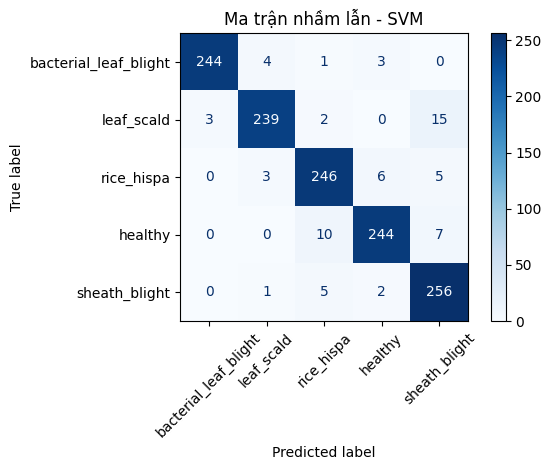

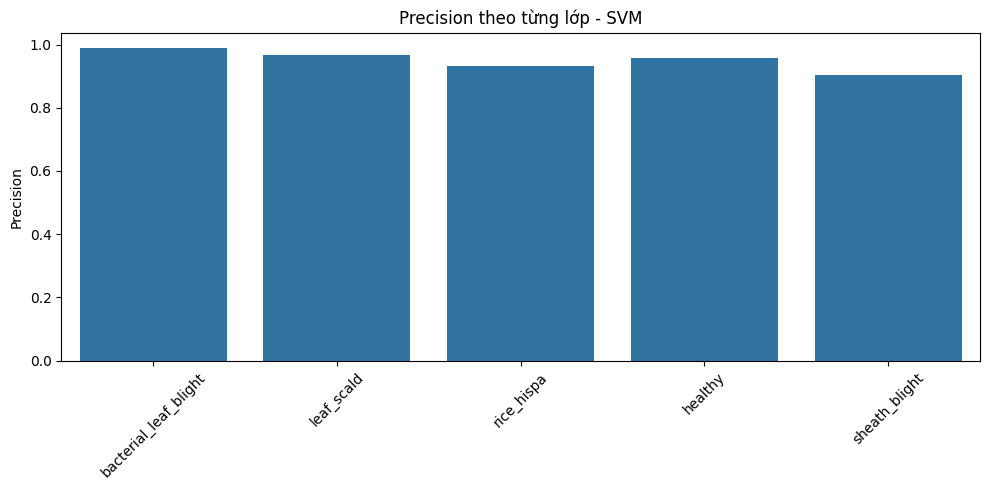

In [ ]:

# ---------------Huấn luyện lại mô hình HOG + Color + SVM tốt nhất -------------
DATA_DIR = "/content/drive/MyDrive/Lua_16:4_HOG+Color_1"


X_train = np.load(os.path.join(DATA_DIR, 'X_train4.npy'))
X_val   = np.load(os.path.join(DATA_DIR, 'X_val4.npy'))
X_test  = np.load(os.path.join(DATA_DIR, 'X_test4.npy'))

y_train = np.load(os.path.join(DATA_DIR, 'y_train4.npy'))
y_val   = np.load(os.path.join(DATA_DIR, 'y_val4.npy'))
y_test  = np.load(os.path.join(DATA_DIR, 'y_test4.npy'))


categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

# ====== Tổng số lượng mẫu ======
print(f"\nSố lượng mẫu:")
print(f"- Train: {len(X_train)} mẫu")
print(f"- Validation: {len(X_val)} mẫu")
print(f"- Test: {len(X_test)} mẫu")

# ====== In ra số lượng mẫu theo từng lớp ======
def print_class_distribution(y, split_name):
    print(f"\nSố lượng mẫu theo từng lớp trong tập {split_name}:")
    counter = Counter(y)
    for label, count in counter.items():
        class_name = categories[label] if label < len(categories) else f"Lớp {label}"
        print(f"  {class_name} ({label}): {count} mẫu")

print_class_distribution(y_train, "Train")
print_class_distribution(y_val, "Validation")
print_class_distribution(y_test, "Test")

# ====== Huấn luyện SVM trên train ======
print("\nĐang huấn luyện mô hình SVM...")
svm_model = SVC(kernel='rbf', C=20.0, gamma='scale')


# Huấn luyện mô hình trên toàn bộ train
svm_model.fit(X_train, y_train)

# ====== Đánh giá trên tập validation ======
y_val_pred = svm_model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
print(f"\n[SVM] Accuracy (val): {val_acc*100:.2f}%")
print(f"[SVM] F1-score (val): {val_f1:.4f}")

# ====== Đánh giá trên tập test ======
y_pred = svm_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\n[SVM] Accuracy (test): {acc*100:.2f}%")
print(f"[SVM] F1-score (test): {f1:.4f}")
print("\n[SVM] Báo cáo phân loại:")
print(classification_report(y_test, y_pred, target_names=categories))

model_filename = os.path.join(DATA_DIR, f'svm_model.pkl')
joblib.dump(svm_model, model_filename)
print(f"\n[SVM] Đã lưu mô hình vào: {model_filename}")

# ====== Vẽ ma trận nhầm lẫn ======
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Ma trận nhầm lẫn - SVM")
plt.tight_layout()
plt.show()

# ====== Precision theo lớp ======
report = classification_report(y_test, y_pred, target_names=categories, output_dict=True)
precision_values = [report[cat]['precision'] for cat in categories]

plt.figure(figsize=(10, 5))
sns.barplot(x=categories, y=precision_values)
plt.ylabel("Precision")
plt.title("Precision theo từng lớp - SVM")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Đang huấn luyện mô hình Random Forest...

[Random Forest] Accuracy (val): 86.27%
[Random Forest] F1-score (val): 0.8648

[Random Forest] Accuracy (test): 86.88%
[Random Forest] F1-score (test): 0.8710

[Random Forest] Báo cáo phân loại:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.99      0.92      0.95       252
           leaf_scald       0.95      0.81      0.87       259
           rice_hispa       0.78      0.90      0.83       260
              healthy       0.99      0.77      0.86       261
        sheath_blight       0.74      0.95      0.83       264

             accuracy                           0.87      1296
            macro avg       0.89      0.87      0.87      1296
         weighted avg       0.89      0.87      0.87      1296



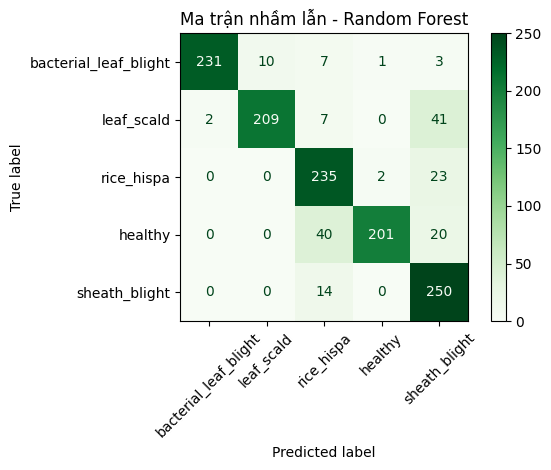

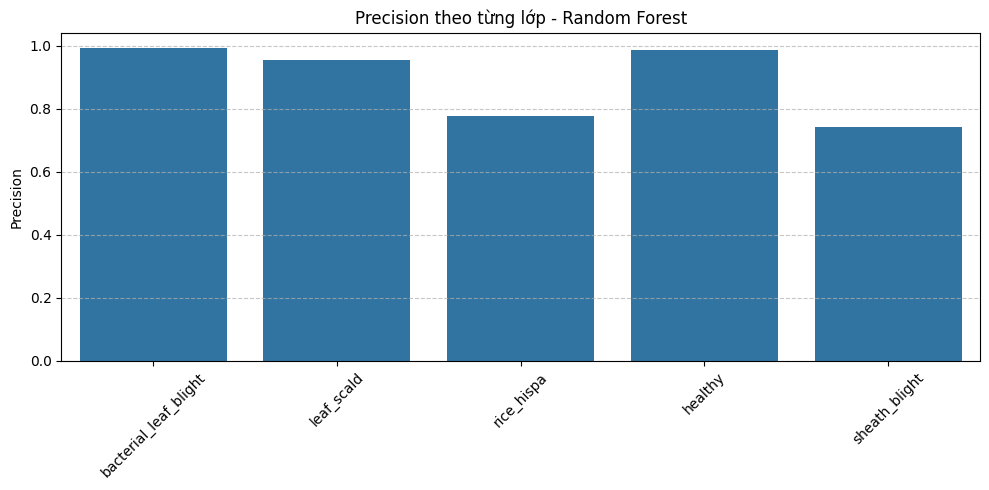

In [ ]:
# ----------- Huấn luyện mô hình Random Forest ---------------

DATA_DIR = "/content/drive/MyDrive/Lua_16:4_HOG+Color_1"

X_train = np.load(os.path.join(DATA_DIR, 'X_train4.npy'))
X_val   = np.load(os.path.join(DATA_DIR, 'X_val4.npy'))
X_test  = np.load(os.path.join(DATA_DIR, 'X_test4.npy'))

y_train = np.load(os.path.join(DATA_DIR, 'y_train4.npy'))
y_val   = np.load(os.path.join(DATA_DIR, 'y_val4.npy'))
y_test  = np.load(os.path.join(DATA_DIR, 'y_test4.npy'))

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]
print("\nĐang huấn luyện mô hình Random Forest...")
rf_model = RandomForestClassifier(n_estimators=250, random_state=42)
rf_model.fit(X_train, y_train)

# ====== Đánh giá trên tập validation ======
y_val_pred_rf = rf_model.predict(X_val)
val_acc_rf = accuracy_score(y_val, y_val_pred_rf)
val_f1_rf = f1_score(y_val, y_val_pred_rf, average='weighted')
print(f"\n[Random Forest] Accuracy (val): {val_acc_rf*100:.2f}%")
print(f"[Random Forest] F1-score (val): {val_f1_rf:.4f}")

# ====== Đánh giá trên tập test ======
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f"\n[Random Forest] Accuracy (test): {acc_rf*100:.2f}%")
print(f"[Random Forest] F1-score (test): {f1_rf:.4f}")
print("\n[Random Forest] Báo cáo phân loại:")
print(classification_report(y_test, y_pred_rf, target_names=categories))

# ====== Vẽ ma trận nhầm lẫn cho Random Forest ======
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=categories)
disp_rf.plot(cmap="Greens", xticks_rotation=45)
plt.title("Ma trận nhầm lẫn - Random Forest")
plt.tight_layout()
plt.show()

# ====== Precision theo lớp - Random Forest ======
report_RF = classification_report(y_test, y_pred_rf, target_names=categories, output_dict=True)
precision_values = [report_RF.get(cat, {}).get('precision', 0.0) for cat in categories]

plt.figure(figsize=(10, 5))
sns.barplot(x=categories, y=precision_values)
plt.ylabel("Precision")
plt.title("Precision theo từng lớp - Random Forest")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Đang huấn luyện mô hình K-Nearest Neighbors...

Đánh giá mô hình K-Nearest Neighbors trên tập validation...

[K-Nearest Neighbors] Accuracy (val): 87.65%
[K-Nearest Neighbors] F1-score (val): 0.8777

Đánh giá mô hình K-Nearest Neighbors trên tập test...

[K-Nearest Neighbors] Accuracy (test): 88.89%
[K-Nearest Neighbors] F1-score (test): 0.8898

[K-Nearest Neighbors] Báo cáo phân loại:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.95      0.94      0.94       252
           leaf_scald       0.93      0.86      0.89       259
           rice_hispa       0.90      0.84      0.87       260
              healthy       0.94      0.85      0.89       261
        sheath_blight       0.77      0.95      0.85       264

             accuracy                           0.89      1296
            macro avg       0.90      0.89      0.89      1296
         weighted avg       0.90      0.89      0.89      1296



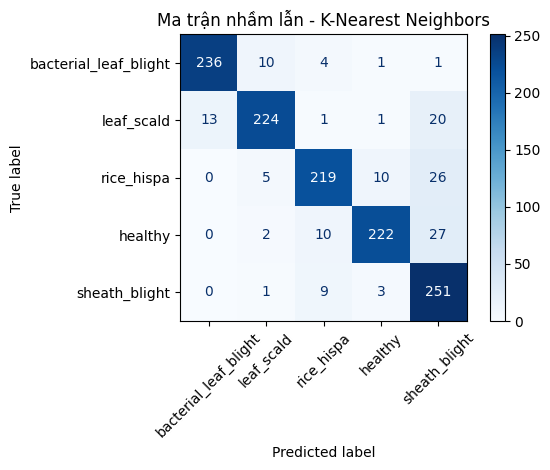

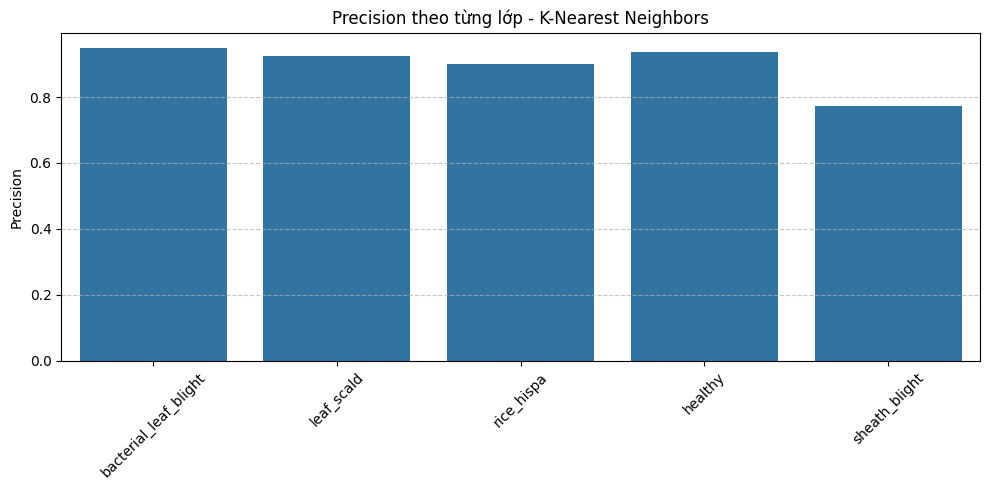

In [ ]:
#-------------- Huấn luyện mô hình K-Nearest Neighbors -------------
DATA_DIR = "/content/drive/MyDrive/Lua_16:4_HOG+Color_1"

X_train = np.load(os.path.join(DATA_DIR, 'X_train4.npy'))
X_val   = np.load(os.path.join(DATA_DIR, 'X_val4.npy'))
X_test  = np.load(os.path.join(DATA_DIR, 'X_test4.npy'))
y_train = np.load(os.path.join(DATA_DIR, 'y_train4.npy'))
y_val   = np.load(os.path.join(DATA_DIR, 'y_val4.npy'))
y_test  = np.load(os.path.join(DATA_DIR, 'y_test4.npy'))

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

print("\nĐang huấn luyện mô hình K-Nearest Neighbors...")

knn_model = KNeighborsClassifier(n_neighbors= 7, weights='distance', p=2)

knn_model.fit(X_train, y_train)


print("\nĐánh giá mô hình K-Nearest Neighbors trên tập validation...")
y_val_pred_knn = knn_model.predict(X_val)
val_acc_knn = accuracy_score(y_val, y_val_pred_knn)
val_f1_knn = f1_score(y_val, y_val_pred_knn, average='weighted')
print(f"\n[K-Nearest Neighbors] Accuracy (val): {val_acc_knn*100:.2f}%")
print(f"[K-Nearest Neighbors] F1-score (val): {val_f1_knn:.4f}")

print("\nĐánh giá mô hình K-Nearest Neighbors trên tập test...")
y_test_pred_knn = knn_model.predict(X_test)
test_acc_knn = accuracy_score(y_test, y_test_pred_knn)
test_f1_knn = f1_score(y_test, y_test_pred_knn, average='weighted')

print(f"\n[K-Nearest Neighbors] Accuracy (test): {test_acc_knn*100:.2f}%")
print(f"[K-Nearest Neighbors] F1-score (test): {test_f1_knn:.4f}")
print("\n[K-Nearest Neighbors] Báo cáo phân loại:")
print(classification_report(y_test, y_test_pred_knn, target_names=categories))

cm_knn = confusion_matrix(y_test, y_test_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=categories)
disp_knn.plot(cmap="Blues", xticks_rotation=45)
plt.title("Ma trận nhầm lẫn - K-Nearest Neighbors")
plt.tight_layout()
plt.show()

# ====== Precision theo lớp - K-Nearest Neighbors ======
report_KNN = classification_report(y_test, y_test_pred_knn, target_names=categories, output_dict=True)
precision_values = [report_KNN.get(cat, {}).get('precision', 0.0) for cat in categories]

plt.figure(figsize=(10, 5))
sns.barplot(x=categories, y=precision_values)
plt.ylabel("Precision")
plt.title("Precision theo từng lớp - K-Nearest Neighbors")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# ------------------ Dữ đoán trên tập dữ liệu mới -------------
categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist_h = cv2.calcHist([hsv_image], [0], None, [bins[0]], [0, 180])
    hist_s = cv2.calcHist([hsv_image], [1], None, [bins[1]], [0, 256])
    hist_v = cv2.calcHist([hsv_image], [2], None, [bins[2]], [0, 256])
    hist_h = cv2.normalize(hist_h, hist_h).flatten()
    hist_s = cv2.normalize(hist_s, hist_s).flatten()
    hist_v = cv2.normalize(hist_v, hist_v).flatten()
    return np.concatenate((hist_h, hist_s, hist_v))

def preprocess_and_extract_features(image_path, hog_scaler, color_scaler):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Không tìm thấy file: {image_path}")

    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Lỗi khi đọc ảnh: {image_path}")

    img = cv2.resize(img, (128, 128))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    hog_feature = hog(
        gray,
        pixels_per_cell=(16, 16),
        cells_per_block=(4, 4),
        block_norm='L1-sqrt',
        feature_vector=True
    )
    color_feature = extract_color_histogram(img)

    hog_feature_scaled = hog_scaler.transform([hog_feature])[0]
    color_feature_scaled = color_scaler.transform([color_feature])[0]

    combined_features = np.concatenate([hog_feature_scaled, color_feature_scaled])
    return combined_features, image_path

def predict_batch_images(image_folder, model, hog_scaler, color_scaler):
    if not os.path.isdir(image_folder):
        raise NotADirectoryError(f"Không phải thư mục: {image_folder}")

    predictions_results = []
    supported_extensions = ('.jpg', '.jpeg', '.png')

    print(f"\n--- Bắt đầu dự đoán trong thư mục: {image_folder} ---\n")

    for filename in os.listdir(image_folder):
        if filename.lower().endswith(supported_extensions):
            image_path = os.path.join(image_folder, filename)
            try:
                features, _ = preprocess_and_extract_features(image_path, hog_scaler, color_scaler)
                prediction_index = model.predict([features])[0]
                predicted_label = categories[prediction_index]
                print(f"{filename} → {predicted_label}")
                predictions_results.append((filename, prediction_index, predicted_label))
            except Exception as e:
                print(f"Lỗi ảnh '{filename}': {e}")
                predictions_results.append((filename, -1, str(e)))
    return predictions_results

model_path = "/content/drive/MyDrive/Lua_16:4_HOG+Color_1/svm_model_best.pkl"
hog_scaler_path = "/content/drive/MyDrive/Lua_16:4_HOG+Color_1/scaler_hog_4.pkl"
color_scaler_path = "/content/drive/MyDrive/Lua_16:4_HOG+Color_1/scaler_color_4.pkl"


svm_model = joblib.load(model_path)
hog_scaler = joblib.load(hog_scaler_path)
color_scaler = joblib.load(color_scaler_path)

test_image_folder = "/content/drive/MyDrive/DATASET/Test_Model_1"
all_predictions = predict_batch_images(test_image_folder, svm_model, hog_scaler, color_scaler)



--- Bắt đầu dự đoán trong thư mục: /content/drive/MyDrive/DATASET/Test_Model_1 ---

bacterial_leaf_blight_5.jpg → rice_hispa
leaf scald_1.jpg → leaf_scald
bacterial_leaf_blight_4.jpg → sheath_blight
bacterial_leaf_blight_3.jpg → bacterial_leaf_blight
bacterial_leaf_blight10.jpg → bacterial_leaf_blight
bacterial_leaf_blight_2.jpg → sheath_blight
bacterial_leaf_blight_8.JPG → bacterial_leaf_blight
bacterial_leaf_blight_1.jpg → bacterial_leaf_blight
bacterial_leaf_blight_6.jpg → bacterial_leaf_blight
bacterial_leaf_blight_7.jpg → healthy
Healthy_1.jpg → healthy
BACTERIALBLIGHT2_11.jpg → bacterial_leaf_blight
leaf scald_5.jpg → leaf_scald
leaf scald_12.png → rice_hispa
Healthy_9.jpg → sheath_blight
Healthy_4.jpg → healthy
Healthy_5.jpg → healthy
Healthy_6.jpg → healthy
leaf scald_2.jpg → leaf_scald
Healthy_7.jpg → rice_hispa
Healthy_3.jpg → healthy
leaf scald_4.jpg → sheath_blight
Healthy_13.jpg → sheath_blight
Healthy_11.png → healthy
Healthy_2.jpg → healthy
Healthy_14.jpg → sheath_bligh